In [1]:
import scalecast
import tensorflow
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
#from scalecast.Forecaster import Forecaster

# import the data
df = pd.read_csv('daily-minimum-temperatures-in-me.csv', parse_dates=['Date'])
# take a look at the data
df.info()

c:\Projetos\time_series_ikileus\.venv\lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        3650 non-null   datetime64[ns]
 1   Daily minimum temperatures  3650 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 57.2+ KB


In [2]:
# data clean up
# convert strings in the data into floats and then drop NAN values
# hint: use convert_dtypes , see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.convert_dtypes.html
data = df.convert_dtypes()

# replace non-numeric values with NaN
data['Daily minimum temperatures'] = pd.to_numeric(data['Daily minimum temperatures'], errors='coerce')

# convert the data into float
data['Daily minimum temperatures'] = data['Daily minimum temperatures'].astype(float)

# drop na values
data = data.dropna()

# after deleting na values, we have to reset index of the time series
# hint : use reset_index with drop=True, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html
# reset index
data = data.reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3647 entries, 0 to 3646
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        3647 non-null   datetime64[ns]
 1   Daily minimum temperatures  3647 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.1 KB


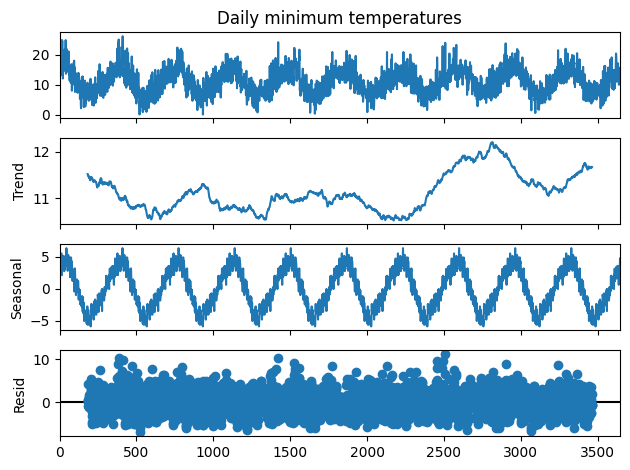

In [3]:
# time series decomposition
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
ts = data['Daily minimum temperatures']
# decompose time series into main components: seanality, trend , residuals
# hint: use seasonal_decompose with period= 365, see https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
result = seasonal_decompose(ts, model='additive', period=365)
# plot the components
result.plot()
pyplot.show()

In [4]:
# prepare input sequences
# splitting the time series into train and test sets
train = ts[:3000]
test = ts[3000:]
# reset test data index
test.reset_index(drop=True, inplace=True)
seq_len = 20
Y_train = []
Y_test = []
X_train = []
X_test = []
# training data
for j in range(len(train) - seq_len):
     
    inp= train[j:j + seq_len]
    out= train[j + seq_len]
    X_train.append(inp)
    Y_train.append(out)    
print(len(X_train))
print(len(Y_train))

2980
2980


In [5]:
# reshape X_train to be [samples, seq_len, 1]
# reshape Y_train to be [samples, 1]
# hint: use np.reshape , see https://numpy.org/doc/stable/reference/generated/numpy.reshape.html
X_train = np.reshape(X_train, (len(X_train), seq_len, 1))
Y_train = np.reshape(Y_train, (len(Y_train), 1))
print(X_train.shape)
print(Y_train.shape)

(2980, 20, 1)
(2980, 1)


In [6]:
# building LSTM 
# dense(units,..), units: Positive integer, dimensionality of the output space;
# dense layer will output the predicted minimum temprature..
# input shape: (seq_len, 1)

import keras
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation
from keras.layers import LSTM
from keras import optimizers

model = Sequential() 

# add an input LSTM layer with 64 units, return_sequence = true, use LSTM(): see https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
model.add(LSTM(64, return_sequences=True, input_shape=(seq_len, 1))) # 64 units

# hidden layer: 32 units
model.add(LSTM(32))# 32 units

# add output layer; use Dense(): see https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
# regression task
model.add(Dense(1)) # 1 unit
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [7]:
# optimizer: use Adam optimizer with learning rate = 0.001, see https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
adam = optimizers.Adam(learning_rate=0.001)
# compile the model, use compile() with adam optimizer and loss= 'mae', see https://keras.io/api/models/model_training_apis/
model.compile(optimizer=adam, loss='mae')
# fit the model on training data, use fit() with 300 epochs, batch_size= 50, see https://keras.io/api/models/model_training_apis/
model.fit(X_train, Y_train, epochs=300, batch_size=50)

Epoch 1/300
60/60 [==============================] - 3s 13ms/step - loss: 6.5208
Epoch 2/300
60/60 [==============================] - 1s 17ms/step - loss: 3.6155
Epoch 3/300
60/60 [==============================] - 1s 16ms/step - loss: 3.1998
Epoch 4/300
60/60 [==============================] - 1s 20ms/step - loss: 2.6788
Epoch 5/300
60/60 [==============================] - 1s 19ms/step - loss: 2.3941
Epoch 6/300
60/60 [==============================] - 1s 17ms/step - loss: 2.2298
Epoch 7/300
60/60 [==============================] - 1s 15ms/step - loss: 2.1460
Epoch 8/300
60/60 [==============================] - 1s 15ms/step - loss: 2.0585
Epoch 9/300
60/60 [==============================] - 1s 15ms/step - loss: 2.0273
Epoch 10/300
60/60 [==============================] - 1s 15ms/step - loss: 1.9963
Epoch 11/300
60/60 [==============================] - 1s 15ms/step - loss: 1.9730
Epoch 12/300
60/60 [==============================] - 1s 15ms/step - loss: 1.9694
Epoch 13/300
60/60 [=====

In [8]:
# testing the model
# prepare testing sequences
# create X_test and Y_test in the same way we created X_train and Y_train above
X_test=[]
Y_test=[]
for j in range(len(test) - seq_len):
     
    inp_test= test[j:j + seq_len]
    out_test= test[j + seq_len]
    X_test.append(inp_test)
    Y_test.append(out_test) 
#reshape test data
X_test = np.reshape(X_test, (len(X_test), seq_len, 1))
print(len(X_test))
print(len(Y_test))

627
627


20/20 [==============================] - 1s 4ms/step


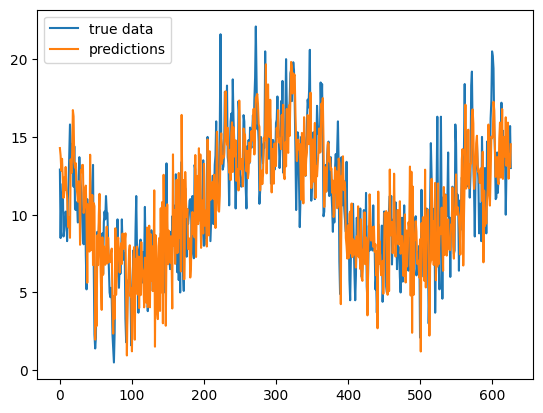

In [9]:
# make predictions on the X_test data, plot actual against predictions
import matplotlib.pyplot as plt
# use model.predict(), see https://keras.io/api/models/model_training_apis/
pred= model.predict(X_test)
plt.plot(Y_test, label ='true data')
plt.plot(pred, label='predictions')
plt.legend(loc="upper left")
plt.show()

In [10]:
# apply holt  exponential smoothing 
# use the same time series 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
import numpy as np


# use pd.Series() to build input sequence of data['Daily minimum temperatures'] with data.index as index of the series
# see https://pandas.pydata.org/docs/reference/api/pandas.Series.html  
train_data = pd.Series(data['Daily minimum temperatures'].values, index=data.index)

# building ES model 
# use Holt() on the train_data with initialization_method="heuristic", see https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.Holt.html
model = Holt(train_data, initialization_method="heuristic")

# fit the model, use smoothing_level=0.9 and smoothing_trend=0.2, see https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.Holt.fit.html#statsmodels.tsa.holtwinters.Holt.fit
fm1 = model.fit(smoothing_level=0.9, smoothing_trend=0.2)
# create 10 out of the sample forecasts using the fitted model, use fm1.forecast()
forecasts = fm1.forecast(10)

c:\Projetos\time_series_ikileus\.venv\lib\site-packages\pandas\util\_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


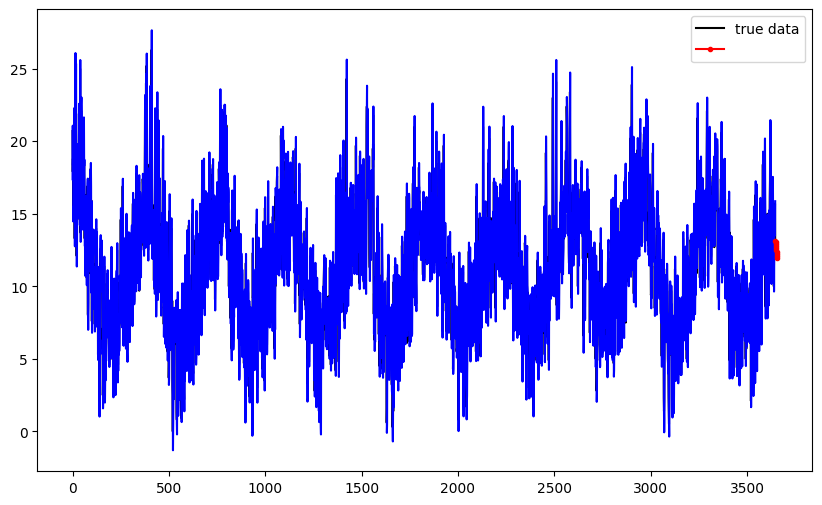

In [11]:
# plot fitted against true values and forecasts
plt.figure(figsize=(10, 6))
# plot the true data
(line0,) = plt.plot(train_data,  color="black")
# add fitted (fm1.fittedvalues) values with color='blue' to the plot, see https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html 
(line1,) = plt.plot(fm1.fittedvalues, color="blue")
(line1,) = plt.plot(forecasts, marker=".", color="red")
plt.legend([line0, line1], ['true data',forecasts.name])
plt.show()